In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from LSsurf.smooth_fit import smooth_fit
from LSsurf.match_priors import match_prior_dz
import pointCollection as pc

In [3]:
%matplotlib widget

In [4]:
# define the domain's width in x, y, and time
W={'x':1.e4,'y':1.e4,'t':12}
# define the grid center:
ctr={'x':0., 'y':0., 't':0.}
# define the grid spacing
p_spacing={'z0':100, 'dz':1000, 'dt':0.25}

In [5]:
# define a grid of data points spanning from 0 to W_x
x0=np.arange(-W['x']/2, W['x']/2+p_spacing['dz'], p_spacing['dz'])
t0=np.arange(-W['t']/2, W['t']/2+p_spacing['dt'], p_spacing['dt'])
lambda_x=5000
prior_amp=10
prior_sigma=0.1

xp, yp, tp=np.meshgrid(x0+W['x']/2, x0, t0)

Dg=pc.grid.data().from_dict({'x':xp[0,:,0].ravel(), 'y':x0,
                             'dz':(tp-t0[0])/W['t']*prior_amp*np.cos(2*np.pi*yp/lambda_x),
                             'time':t0, 'sigma_dz':np.zeros_like(xp)+prior_sigma})

Dg.to_h5('match_dz_data.h5', group='dz', replace=True)


In [6]:
#Define a minimal dataset (so that the 'data' variable is not empty) 
# that constrains the left-hand side of the solution at time=-0.5
y=np.arange(-W['y']/2, W['y']/2+100, 1000)
lambda_x=2000
data_sigma=100
D=pc.data().from_dict({'x':np.zeros_like(y)-W['x']/2+1000, 'y':y,'z':np.zeros_like(y),
                       'time':np.zeros_like(y)-0.5, 'sigma':np.zeros_like(y)+data_sigma})
# To ensure a time-constant simulation, replicate the data at times -0.5 and 0.5:
data=pc.data().from_list([D, D.copy().assign({'time':np.zeros_like(y)+0.5})])


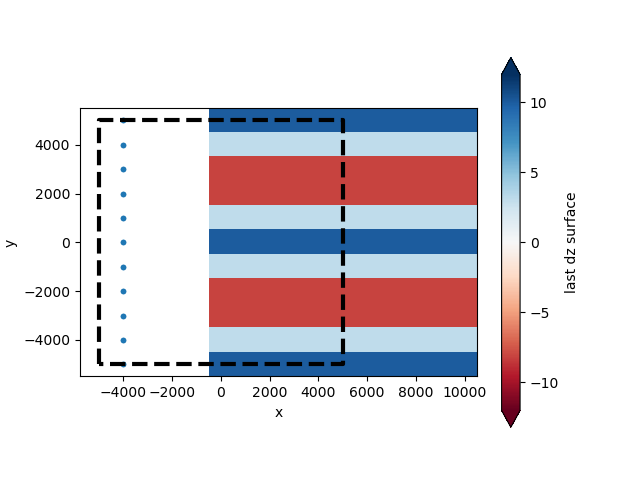

In [78]:
plt.figure()
plt.imshow(Dg.dz[:,:,-1], extent=Dg.img_extent, origin='lower', cmap='RdBu', clim=[-12, 12])
plt.plot(data.x, data.y,'.')
h_cb=plt.colorbar(label='last dz surface', extend='both')
h_cb.vmin=-10
h_cb.vmax=10
plt.xlabel('x')
plt.ylabel('y')

plt.plot(W['x']/2*np.array([-1, -1, 1, 1, -1]), W['y']/2*np.array([-1, 1, 1, -1, -1]),'k--', linewidth=3)
plt.gca().set_aspect(1)


In [76]:
dir(h_cb)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_solids',
 '_add_solids_patches',
 '_boundaries',
 '_cbar_cla',
 '_do_extends',
 '_draw_all',
 '_extend_cid1',
 '_extend_cid2',
 '_extend_lower',
 '_extend_patches',
 '_extend_upper',
 '_filled',
 '_formatter',
 '_forward_boundaries',
 '_get_extension_lengths',
 '_get_ticker_locator_formatter',
 '_get_view',
 '_inside',
 '_interactive_funcs',
 '_inverse_boundaries',
 '_locate',
 '_locator',
 '_long_axis',
 '_mesh',
 '_minorformatter',
 '_minorlocator',
 '_process_values',
 '_proportional_y',
 '_reset_locator_formatter_scale',
 '_set_scale',
 '_set_view',
 '_set_view_from_bbox',
 '_short_axis',
 '_uni

In [77]:
?plt.colorbar

Signature:
plt.colorbar(
    mappable: 'ScalarMappable | None' = None,
    cax: 'matplotlib.axes.Axes | None' = None,
    ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None,
    **kwargs,
) -> 'Colorbar'
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
    `.ContourSet`, etc.) described by this colorbar.  This argument is
    mandatory for the `.Figure.colorbar` method but optional for the
    `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to
    generate colorbars not attached to a previously drawn artist, e.g.
    ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.  If `None`, then a new
    Axes is created and the space for it will be stolen from the Axes(s)
    specified in *ax*.


In [29]:
# calculate a smooth-fit surface using the data grid as a prior constraint

In [13]:
E_d3zdx2dt=0.001
E_d2z0dx2=0.01
E_d2zdt2=4000

data_gap_scale=5000
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

prior_args={'filenames':['match_dz_data.h5']}

m_spacing={'z0':100, 'dz':1000, 'dt':0.25}
ref_epoch=np.ceil(W['t']/m_spacing['dt']/2.)

# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=m_spacing, E_RMS=E_RMS,
                 reference_epoch=ref_epoch, compute_E=True,
                 max_iterations=1, prior_args=prior_args,
                 VERBOSE=True,
                 dzdt_lags=[1])


smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
initial: 21:
starting qr solve for iteration 0 at Tue Jun 11 09:01:19 2024
found 22 in TSE, dt=  3
	 median(sigma_extra)=0.0000
Starting uncertainty calculation
	Uncertainty propagation took 17.18 seconds


Text(0, 0.5, 'Error')

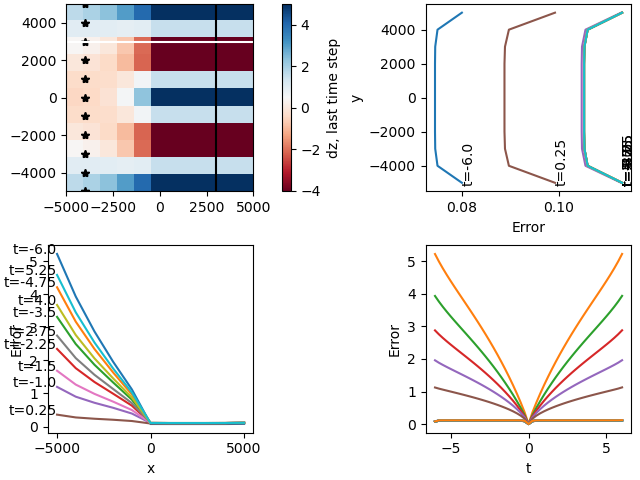

In [64]:
hfig, hax=plt.subplots(2, 2, layout='constrained'); hax=hax.ravel()
hi=hax[0].imshow(S['m']['dz'].dz[:,:,-1], extent=S['m']['dz'].extent, origin='lower', cmap='RdBu'); 
plt.colorbar(mappable=hi, ax=hax[0], label='dz, last time step')
hax[0].plot(data.x, data.y,'k*')
hax[0].plot(S['E']['sigma_dz'].x[-3]+np.zeros(S['E']['sigma_dz'].shape[0]), S['E']['sigma_dz'].y, 'k')
hax[0].plot(S['E']['sigma_dz'].x, S['E']['sigma_dz'].y[-3]+np.zeros(S['E']['sigma_dz'].shape[1]), 'w')

labels=[f't={ti}' for ti in S['E']['sigma_dz'].time[::5]]
hax[1].plot(S['E']['sigma_dz'].sigma_dz[:, -3, ::5], S['E']['sigma_dz'].y, label=labels); hax[1].set_xlabel('Error'); hax[1].set_ylabel('y')
for label, si in zip(labels, S['E']['sigma_dz'].sigma_dz[0, -3, ::5]):
    hax[1].text(si, S['E']['sigma_dz'].y[0], label, rotation=90)

hax[2].plot(S['E']['sigma_dz'].x, S['E']['sigma_dz'].sigma_dz[-3, :, ::5], label=labels); hax[2].set_ylabel('Error'); hax[2].set_xlabel('x')
for label, si in zip(labels, S['E']['sigma_dz'].sigma_dz[-3, 0, ::5]):
    hax[2].text(S['E']['sigma_dz'].x[0], si, label, ha='right')

hax[3].plot(S['E']['sigma_dz'].time[:], S['E']['sigma_dz'].sigma_dz[:,-3,:].T)
hax[3].plot(S['E']['sigma_dz'].time[:], S['E']['sigma_dz'].sigma_dz[-3,:,:].T)
hax[3].set_xlabel('t'); hax[3].set_ylabel('Error')



In [55]:
si

array([0.07996268, 0.11308289, 0.1130843 , 0.11308424, 0.11308148,
       0.11290061, 0.        , 0.1129006 , 0.11308148, 0.11308424,
       0.11308431, 0.11308495, 0.12013065])

In [16]:
t_ind = np.flatnonzero(S['E']['sigma_dz'].time==2)
x_ind = np.flatnonzero(S['E']['sigma_dz'].x==3000)
y_ind = np.flatnonzero(S['E']['sigma_dz'].y==0)

S['E']['sigma_dz'].sigma_dz[y_ind, x_ind, t_ind]


array([0.10521561])

In [18]:
S_dict_sigma={}
for this_sigma_prior in [0.01, 0.05, 0.1, 0.5, 1., 5., 10.]:
    print(f'σ_prior = {this_sigma_prior}')
    D_prior=pc.grid.data().from_dict({'x':xp[0,:,0].ravel(), 'y':x0,
                             'dz':(tp-t0[0])/W['t']*prior_amp*np.cos(2*np.pi*yp/lambda_x),
                             'time':t0, 'sigma_dz':np.zeros_like(xp)+this_sigma_prior})
    D_prior.to_h5('match_dz_data.h5', group='dz', replace=True)
    S_dict_sigma[this_sigma_prior]=\
        smooth_fit(data=data, ctr=ctr, W=W, spacing=m_spacing, E_RMS=E_RMS,
                 reference_epoch=ref_epoch, compute_E=True,
                 max_iterations=1, prior_args=prior_args,
                 VERBOSE=False,
                 dzdt_lags=[1])    



σ_prior = 0.01
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 0.05
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 0.1
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 0.5
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 1.0
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 5.0
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}
σ_prior = 10.0
smooth_fit: E_RMS={'d2z0_dx2': 0.01, 'dz0_dx': 50.0, 'd3z_dx2dt': 0.001, 'd2z_dxdt': 5.0, 'd2z_dt2': 4000}


Text(0, 0.5, '$σ_{dz}$')

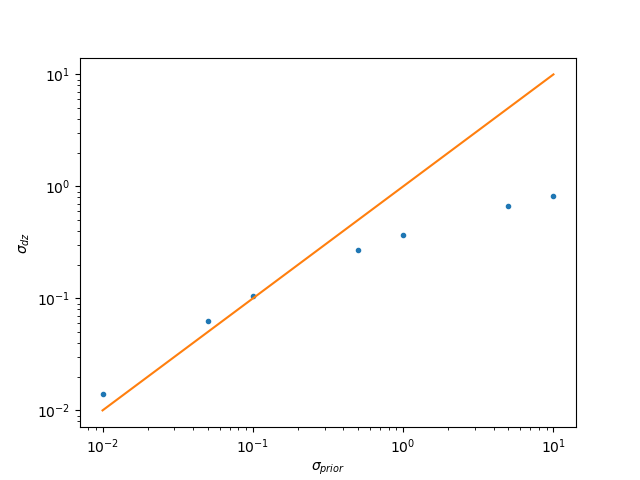

In [21]:
sigma_prior_vals=np.array(list(S_dict_sigma.keys()))
sigma_dz_vals=sigma_prior_vals*np.NaN

for ii, key in enumerate(sigma_prior_vals):
    Si =S_dict_sigma[key]

    t_ind = np.flatnonzero(Si['E']['sigma_dz'].time==2)
    x_ind = np.flatnonzero(Si['E']['sigma_dz'].x==3000)
    y_ind = np.flatnonzero(Si['E']['sigma_dz'].y==0)

    sigma_dz_vals[ii] = Si['E']['sigma_dz'].sigma_dz[y_ind, x_ind, t_ind]

plt.figure(); plt.loglog(sigma_prior_vals, sigma_dz_vals,'.')
plt.loglog(sigma_prior_vals, sigma_prior_vals)
plt.gca().set_xlabel('$σ_{prior}$')
plt.gca().set_ylabel('$σ_{dz}$')

Assume that $\sigma$ values are equal to the error-weighted sum of two components: 
$$sigma^{-2} = (A \sigma_d)^{-2} + \sigma_{bg}^{-2}$$


In [22]:
G=np.c_[sigma_prior_vals**-2, np.ones_like(sigma_prior_vals)]
m=np.linalg.inv(G.T.dot(G)).dot(G.T).dot(sigma_dz_vals**-2)

minv2=m**-2
plt.plot(sigma_prior_vals, ((minv2[0]*sigma_prior_vals)**-2+minv2[1]**-1)**-2, label='inverse-squared weight')

Assume that $\sigma$ values are equal to the error-weighted sum of two components: 
$$sigma^{-1} = (A \sigma_d)^{-1} + \sigma_{bg}^{-1}$$


In [23]:
G=np.c_[sigma_prior_vals**-1, np.ones_like(sigma_prior_vals)]
m=np.linalg.inv(G.T.dot(G)).dot(G.T).dot(sigma_dz_vals**-1)

minv=m**-1
plt.plot(sigma_prior_vals, ((minv[0]*sigma_prior_vals)**-1+minv[1]**-1)**-1, label='inverse weight')

In [24]:
plt.legend()

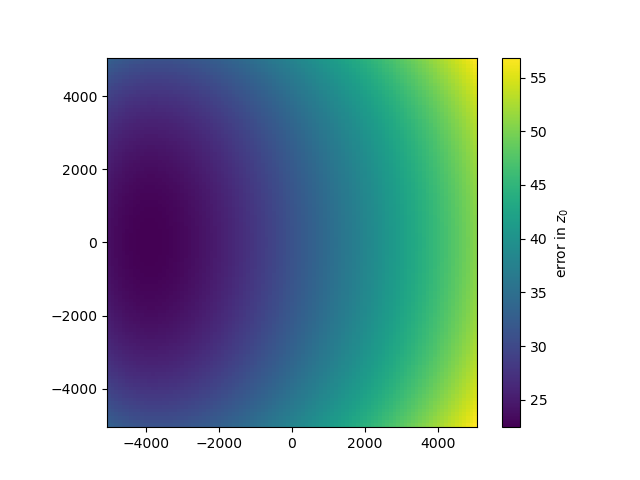

In [27]:
plt.figure(); hi=S['E']['sigma_z0'].show(field='sigma_z0'); plt.colorbar(hi, label='error in $z_0$')